<h1 style = "color: skyblue; font-family: Arial; font-size: 50 px; text-align: center;">Bitcoin Price Trend prediction using Machine Learning </h1>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta

import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime


<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Data Collection</h2>

In [2]:
ticker = 'BTC-USD'
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start_date, end_date)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-28,61612.804688,62126.097656,59985.402344,60320.136719,60320.136719,24952866877
2024-06-29,60319.875000,61097.621094,60300.964844,60887.378906,60887.378906,12652903396
2024-06-30,60888.445312,62892.828125,60632.949219,62678.292969,62678.292969,17333226409
2024-07-01,62673.605469,63777.226562,62495.511719,62851.980469,62851.980469,25468379421
2024-07-02,62844.410156,63203.359375,61752.746094,62029.015625,62029.015625,20151616992


In [4]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
data.shape

(1645, 6)

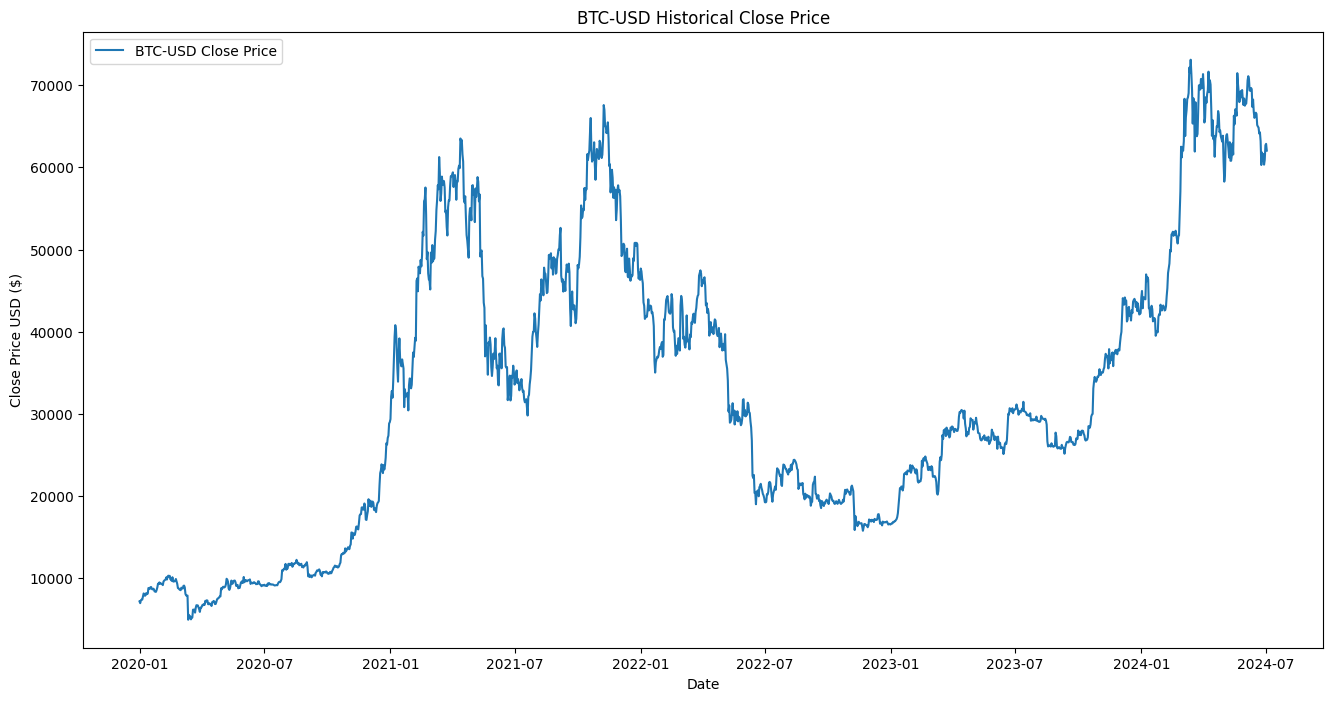

In [6]:
# Visualize closing price
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Historical Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data['Close'], label =f'{ticker} Close Price')
plt.legend()
plt.show()

<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Feature Engineering</h2>

In [7]:
# Imporve the dataset with technical indicators
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=20)
data['MA40'] = ta.sma(data['Close'], length=40)
data['MA80'] = ta.sma(data['Close'], length=80)
data['MA160'] = ta.sma(data['Close'], length=160)
data['EMA_12'] = ta.ema(data['Close'], length=12)
data['RSI'] = ta.rsi(data['Close'], length=14)
macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
bollinger = ta.bbands(data['Close'], length=20, std=2)
data['Bollinger_Upper'] = bollinger['BBU_20_2.0']
data['Bollinger_Lower'] = bollinger['BBL_20_2.0']

# Create the target set
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

# Drop rows with NaN values after calculating indicators
data.dropna(inplace=True)

# Visualize data
data.head()

,Open,High,Low,Close,Adj Close,Volume,ATR,MA40,MA80,MA160,EMA_12,RSI,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower,Target
Date,,,,,,,,,,,,,,,,,
2020-06-08,9760.063477,9782.306641,9675.885742,9771.489258,9771.489258,21486346312,361.275640,9345.505981,8149.530878,8339.098956,9630.521929,56.728476,218.960031,228.100005,10147.925758,8736.105199,1
2020-06-09,9774.360352,9836.369141,9664.719727,9795.700195,9795.700195,23717842783,351.794329,9373.934644,8194.663800,8355.320993,9655.933970,57.098627,215.917384,225.663481,10177.643830,8733.659002,1
2020-06-10,9794.119141,9908.896484,9728.291016,9870.094727,9870.094727,25706567601,343.234886,9399.067847,8245.161798,8373.349896,9688.881779,58.279597,217.007552,223.932295,10217.184613,8772.951520,0
2020-06-11,9870.078125,9938.297852,9263.069336,9321.781250,9321.781250,30247143440,359.834567,9407.397461,8281.480127,8385.705502,9632.404775,47.829185,171.648546,213.475545,10214.582886,8789.473657,1
2020-06-12,9320.690430,9540.465820,9285.851562,9480.843750,9480.843750,22610564515,354.573552,9421.981836,8315.805627,8398.644171,9609.087694,50.596739,146.843501,200.149137,10215.568193,8815.644014,0


<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Split and Normalize the Data</h2>

In [8]:
# Prepare features and target
features = ['ATR','MA40','MA80','MA160','EMA_12', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume']
X = data[features]
y = data['Target']


# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Split the features and target to training and testing sets
train_size = int(len(scaled_data)*0.8)
X_train, X_test = scaled_data[:train_size], scaled_data[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Model Training and Evaluation</h2>

In [9]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Best Parameters for Random Forest: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest Performance:
Accuracy: 0.5201342281879194
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.69      0.58       140
           1       0.57      0.37      0.45       158

    accuracy                           0.52       298
   macro avg       0.53      0.53      0.51       298
weighted avg       0.54      0.52      0.51       298

Confusion Matrix:


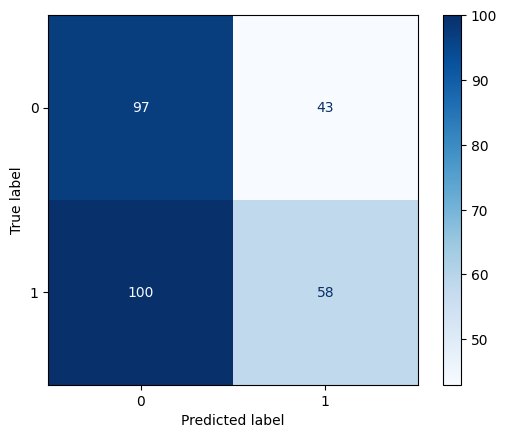

In [10]:
# Classifier 1: Hyperparameter Tuning for Random Forest
rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print(f'Best Parameters for Random Forest: {grid_search_rf.best_params_}')
best_rf_model = grid_search_rf.best_estimator_
print('Random Forest Performance:')
evaluate_model(best_rf_model, X_test, y_test)

Best Parameters for Logistic Regression: {'C': 0.1}
Logistic Regression Performance:
Accuracy: 0.4697986577181208
Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       140
           1       0.00      0.00      0.00       158

    accuracy                           0.47       298
   macro avg       0.23      0.50      0.32       298
weighted avg       0.22      0.47      0.30       298

Confusion Matrix:


C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_cla

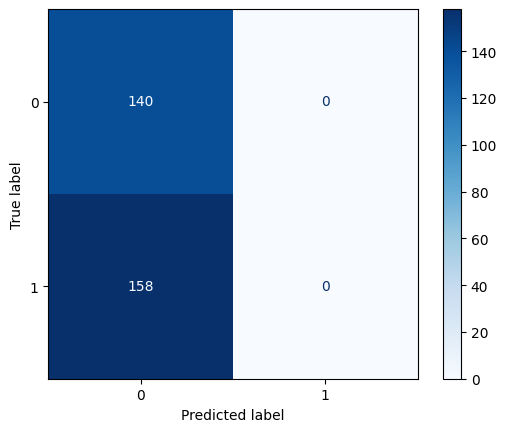

In [11]:
# Classifier 2: Hyperparameter Tuning for Logistic Regression
lr_model = LogisticRegression(random_state=42)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
print(f'Best Parameters for Logistic Regression: {grid_search_lr.best_params_}')
best_lr_model = grid_search_lr.best_estimator_
print('Logistic Regression Performance:')
evaluate_model(best_lr_model, X_test, y_test)

Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Gradient Boosting Performance:
Accuracy: 0.4865771812080537
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.97      0.64       140
           1       0.69      0.06      0.11       158

    accuracy                           0.49       298
   macro avg       0.58      0.51      0.37       298
weighted avg       0.59      0.49      0.36       298

Confusion Matrix:


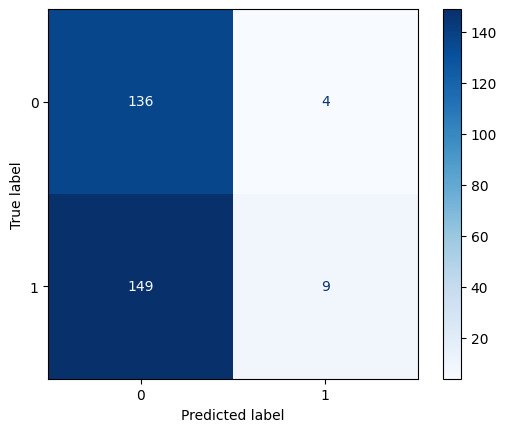

In [12]:
# Classifier 3: Hyperparameter Tuning for Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
print(f'Best Parameters for Gradient Boosting: {grid_search_gb.best_params_}')
best_gb_model = grid_search_gb.best_estimator_
print('Gradient Boosting Performance:')
evaluate_model(best_gb_model, X_test, y_test)

Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
XGBoost Performance:
Accuracy: 0.4865771812080537
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.97      0.64       140
           1       0.69      0.06      0.11       158

    accuracy                           0.49       298
   macro avg       0.58      0.51      0.37       298
weighted avg       0.59      0.49      0.36       298

Confusion Matrix:


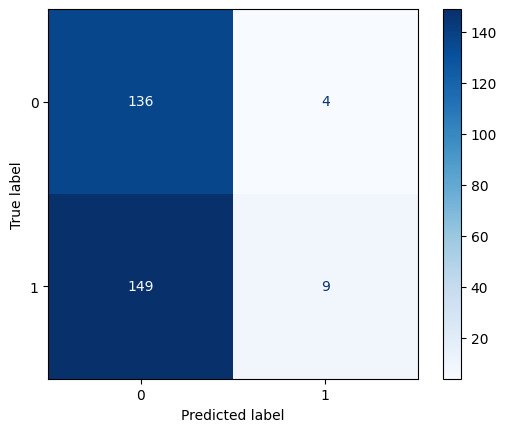

<Figure size 1000x600 with 0 Axes>

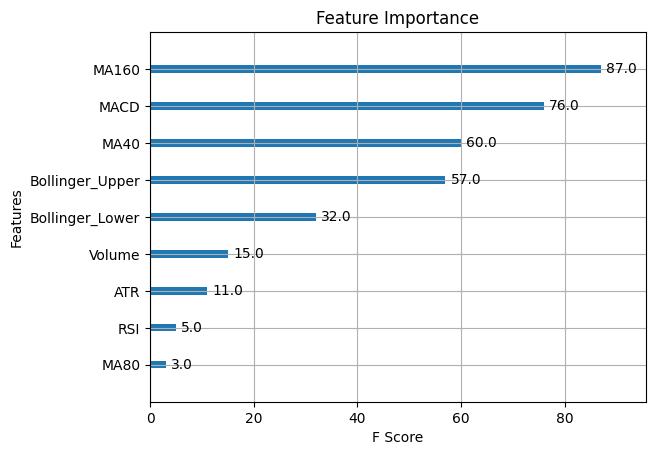

In [13]:
# Classifier 4: Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
print(f'Best Parameters for XGBoost: {grid_search_xgb.best_params_}')
best_xgb_model = grid_search_xgb.best_estimator_
print('XGBoost Performance:')
evaluate_model(best_xgb_model, X_test, y_test)

# Plot feature importance with the fitted best_xgb_model
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', title='Feature Importance', xlabel='F Score', ylabel='Features')
ax = plt.gca()
feature_importances = best_xgb_model.get_booster().get_score(importance_type='weight')
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
ax.set_yticklabels([features[int(f.split('f')[1])] for f, _ in sorted_features])

plt.show()



In [14]:
# Backtesting with the best-performing model (Random Forest)
def backtest(data, model, scaler):
    data[features] = scaler.transform(data[features])
    data['Prediction'] = model.predict(data[features])
    data['Strategy_Return'] = data['Prediction'].shift(1) * data['Close'].pct_change()
    data['Market_Return'] = data['Close'].pct_change()
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()
    data['Cumulative_Market_Return'] = (1 + data['Market_Return']).cumprod()
    return data

backtest_results = backtest(data.copy(), best_rf_model, scaler)

C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


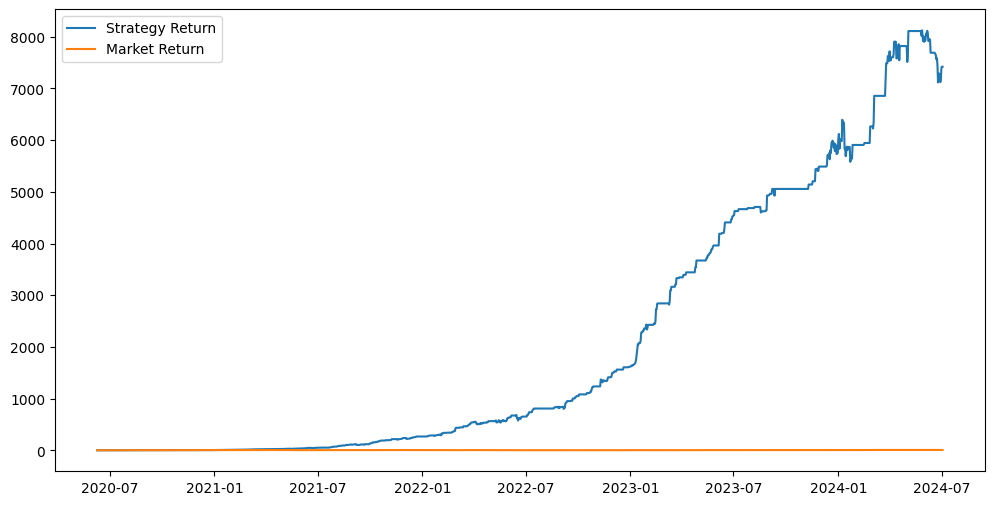

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Cumulative_Strategy_Return'], label='Strategy Return')
plt.plot(backtest_results.index, backtest_results['Cumulative_Market_Return'], label='Market Return')
plt.legend()
plt.show()